# TSFEL predicting Normal Vs. Pathological knee

To perform this example every cell must be executed. To do so click run ([  ]) in the top left of every cell.

The first step consists of importing TSFEL library. To do so press play. 

The import can take few seconds, but the run button will change so that you know that the import has started and ended.

A warning will appear to reset all runtimes before running, click to accept.

In [1]:
#@title Import Time Series Feature Extraction Library
import warnings
warnings.filterwarnings('ignore')
!pip install https://github.com/fraunhoferportugal/tsfel/archive/v0.1.3-dev.zip
!pip install pandas_profiling
!pip install patool
from sys import platform
if platform == "linux" or platform == "linux2":
    !wget http://archive.ics.uci.edu/ml/machine-learning-databases/00278/SEMG_DB1.rar
else:
    !pip install wget
    import wget
    wget.download('http://archive.ics.uci.edu/ml/machine-learning-databases/00278/SEMG_DB1.rar');

  Using cached https://github.com/fraunhoferportugal/tsfel/archive/v0.1.3-dev.zip
  Stored in directory: C:\Users\letic\AppData\Local\pip\Cache\wheels\b8\15\68\c1dcf7d4d101d5aa781a2d082b6fb0730676228bd8cfd2a5d9
Successfully built tsfel
100% [........................................................................] 14440981 / 14440981

In [2]:
# Import libraries
import glob
import itertools
import patoolib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.interpolate as interp
import tsfel
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

# Unzip dataset
patoolib.extract_archive("SEMG_DB1.rar");

patool: Extracting SEMG_DB1.rar ...
patool: running "C:\Program Files\WinRAR\rar.EXE" x -- "C:\Users\letic\OneDrive\Área de Trabalho\notebook_test\SEMG_DB1.rar"
patool:     with cwd=.\Unpack_44s01kgj
patool: ... SEMG_DB1.rar extracted to `SEMG_DB1' (multiple files in root).


### Data pre-processing###
Method to interpolate each file data (EMG and goniometer signals) to the same sample size.

In [3]:
def preprocess(data):
    """Interpolating the EMG and goniometer to the same sample size

      Parameters
      ----------
      data list of pandas DataFrame
        EMG and gonomioter signals for a given activity
      Returns
      -------
        Interpolated data (list of nd-array)

    """
    data = [interp.interp1d(np.arange(len(x[0].dropna())), x[0].dropna(), axis=0, kind='nearest')(np.linspace(0, len(x[0].dropna()) - 1, len(x[0].iloc[:, 0].dropna()))) for x in data]
    return data

## Dataset

The dataset was acquired by Batallón de sanidad (BASAN) in collaboration with the Universidad Militar Nueva Granada – Bogotá. The protocol was performed by 22 male subjects, 11 with different knee abnormalities previously diagnosed by a professional and other 11 without any known knee pathology. The participants were required to perform 3 different exercises: (1) **walk**, (2) **extension of the leg from the sit position** and (3) **flexion of the knee stand up**.

The acquisition process was conducted with 4 electrodes placed on the following muscles (vastus internus, semitendinosus, biceps femoris and rectus femoris) and a goniometer in the knee.

 
**For this example, we will only be using files from the (2) activity and data from rectus femoris muscle and from the goniometer sensor. The classifier will predict if the participant has a normal or pathological knee.**

In [4]:
# @title Loading normal and pathological files from extension of the leg from the sit position
normal_files = glob.glob("*/N_TXT/*.txt")
patholo_files = glob.glob("*/A_TXT/*.txt")

normalfl = [[pd.read_csv(fl, sep='\t', skiprows=7, usecols=(0, 4), header=None).dropna()] for fl in
            normal_files if
            'Npie' in fl]

patholofl = [[pd.read_csv(fl, sep='\t', skiprows=7, usecols=(0, 4), header=None).dropna()] for fl in
             patholo_files if 'Apie' in fl]

In [5]:
# @title Train and test set
# dataset sampling frequency, according to dataset information
fs = 1000
# window size for window splitter method (each window has 1 seconds)
window_size = 1000 

# Interpolating data
normalfl = preprocess(normalfl)
patholofl = preprocess(patholofl)

# Dividing into train and test sets. Splitting signal in windows
# Using 2 normal files and 2 pathological files for test set
x_train = list(itertools.chain(*[tsfel.signal_window_spliter(signal[i], window_size, overlap=0) for signal in
                                 [normalfl, patholofl] for i in range(len(normalfl) - 2)]))

x_test = list(itertools.chain(*[tsfel.signal_window_spliter(signal[i], window_size, overlap=0) for signal in
                                [normalfl, patholofl] for i in [len(normalfl) - 2, len(normalfl) - 1]]))

y_train = np.concatenate(
    (np.repeat(0, np.cumsum([int(len(normalfl[i]) / window_size) for i in range(len(normalfl) - 2)])[-1]),
     np.repeat(1, np.cumsum([int(len(patholofl[i]) / window_size) for i in range(len(patholofl) - 2)])[-1])))

y_test = np.concatenate((np.repeat(0, np.cumsum([int(len(normalfl[i]) / window_size) for i in [len(normalfl) - 2, len(normalfl) - 1]])[-1]),
                         np.repeat(1, np.cumsum([int(len(patholofl[i]) / window_size) for i in [len(patholofl) - 2, len(patholofl) - 1]])[-1])))



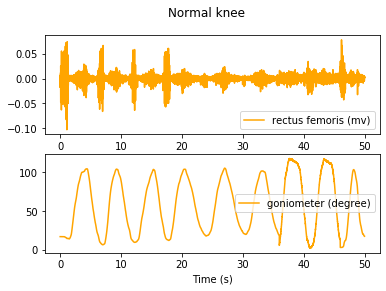

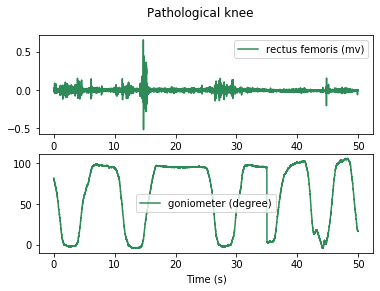

In [6]:
# @title Visualizing signals
nsignal = np.concatenate(x_train[:50])
asignal = np.concatenate(x_train[-50:])
time = np.linspace(0, len(nsignal)* 1/fs, len(nsignal))
c = ['orange', 'seagreen']
title = ['Normal knee', 'Pathological knee']

for i, signal in enumerate([nsignal, asignal]):
    plt.figure(i)
    plt.subplot(211)
    plt.plot(time, signal[:, 0], color=c[i], label='rectus femoris (mv)')
    plt.legend()
    plt.subplot(212)
    plt.plot(time, signal[:, 1], color=c[i], label='goniometer (degree)')
    plt.legend()
    plt.suptitle(title[i])

    plt.xlabel("Time (s)")

In [7]:
# Extract all features' domains (spectral, statistical and temporal)
cfg_file = tsfel.get_features_by_domain()
X_train = tsfel.time_series_features_extractor(cfg_file, x_train, fs=fs, header_names = np.array(['emg', 'gon']))
X_test = tsfel.time_series_features_extractor(cfg_file, x_test, fs=fs, header_names = np.array(['emg', 'gon']))

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


In [8]:
# @title Handling eventual missing values from the feature extraction
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(X_train.mean(), inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

In [9]:
# @title Removal of highly correlated features
corr_features = tsfel.correlated_features(X_train)
print('Highly correlated features: ' + '; '.join(corr_features))
for rej in corr_features:
    X_train = X_train.drop(rej, axis=1)
    X_test = X_test.drop(rej, axis=1)

Highly correlated features: emg_Autocorrelation; emg_ECDF Percentile Count_1; emg_ECDF_1; emg_ECDF_2; emg_ECDF_3; emg_ECDF_5; emg_ECDF_6; emg_ECDF_7; emg_ECDF_8; emg_ECDF_9; emg_FFT mean coefficient_105; emg_FFT mean coefficient_11; emg_FFT mean coefficient_113; emg_FFT mean coefficient_115; emg_FFT mean coefficient_123; emg_FFT mean coefficient_126; emg_FFT mean coefficient_127; emg_FFT mean coefficient_128; emg_FFT mean coefficient_130; emg_FFT mean coefficient_133; emg_FFT mean coefficient_135; emg_FFT mean coefficient_137; emg_FFT mean coefficient_139; emg_FFT mean coefficient_141; emg_FFT mean coefficient_142; emg_FFT mean coefficient_144; emg_FFT mean coefficient_146; emg_FFT mean coefficient_147; emg_FFT mean coefficient_149; emg_FFT mean coefficient_150; emg_FFT mean coefficient_152; emg_FFT mean coefficient_154; emg_FFT mean coefficient_158; emg_FFT mean coefficient_162; emg_FFT mean coefficient_163; emg_FFT mean coefficient_164; emg_FFT mean coefficient_171; emg_FFT mean coef

In [10]:
#@title Remove low variance features
selector = VarianceThreshold()
X_train = selector.fit_transform(X_train)
X_test = selector.transform(X_test)

In [11]:
#@title Normalising Features
min_max_scaler = preprocessing.StandardScaler()
nX_train = min_max_scaler.fit_transform(X_train)
nX_test = min_max_scaler.transform(X_test)

### Using Decision Tree classifier

In [12]:
classifier = DecisionTreeClassifier()

# Train the classifier
classifier.fit(nX_train, y_train.ravel())

# Predict on test data
y_predict = classifier.predict(nX_test)

condition_labels = ['Normal', 'Pathological']

# Get the classification report
accuracy = accuracy_score(y_test, y_predict) * 100
print(classification_report(y_test, y_predict, target_names = condition_labels))
print("Accuracy: " + str(accuracy) + '%')

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        40
Pathological       1.00      1.00      1.00        37

   micro avg       1.00      1.00      1.00        77
   macro avg       1.00      1.00      1.00        77
weighted avg       1.00      1.00      1.00        77

Accuracy: 100.0%


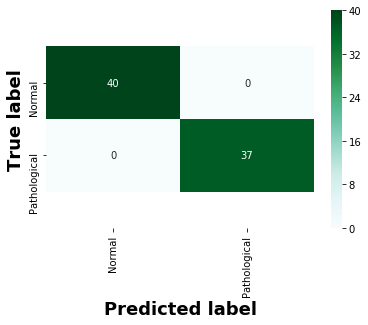

In [13]:
#@title Confusion Matrix
cm = confusion_matrix(y_test, y_predict)
df_cm = pd.DataFrame(cm, index=[i for i in condition_labels], columns = [i for i in condition_labels])
plt.figure()
ax = sns.heatmap(df_cm, cbar = True, cmap="BuGn", annot = True, fmt = 'd')
plt.setp(ax.get_xticklabels(), rotation = 90)
plt.ylabel('True label', fontweight = 'bold', fontsize = 18)
plt.xlabel('Predicted label', fontweight = 'bold', fontsize = 18)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

All features domains were used in the feature extraction step. Accordingly, the Decision Tree classifier obtained high accuracy and was able to distinguish between normal and pathological knee condition during the extension of the leg from the sit position activity.